In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 드라이브 내 위치로 이동
%cd /content/drive/MyDrive
!unzip FedAvg-Pytorch-main.zip
%cd FedAvg-Pytorch-main

/content/drive/MyDrive
Archive:  FedAvg-Pytorch-main.zip
fb62f4b8b99f9f3e7ad826d5fd7184fa26b5f82c
replace FedAvg-Pytorch-main/Fed_Avg.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Fed_Avg.ipynb  
replace FedAvg-Pytorch-main/Plots/IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/IID.png  
replace FedAvg-Pytorch-main/Plots/Non-IID.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/Plots/Non-IID.png  
replace FedAvg-Pytorch-main/README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/README.md  
replace FedAvg-Pytorch-main/data.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/data.py  
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m10.npy  
replace FedAvg-Pytorch-main/models_fedavg/acc_cnn_iid_m50.npy? [y]es, [n]o, [A]ll,

In [ ]:
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from util import view_10
from data import fetch_dataset, data_to_tensor, iid_partition_loader, noniid_partition_loader

In [ ]:
# setting random seeds
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

In [ ]:
# hyperparams
bsz = 10

In [ ]:
# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are currently using this device:", device)

We are currently using this device: cuda


60000


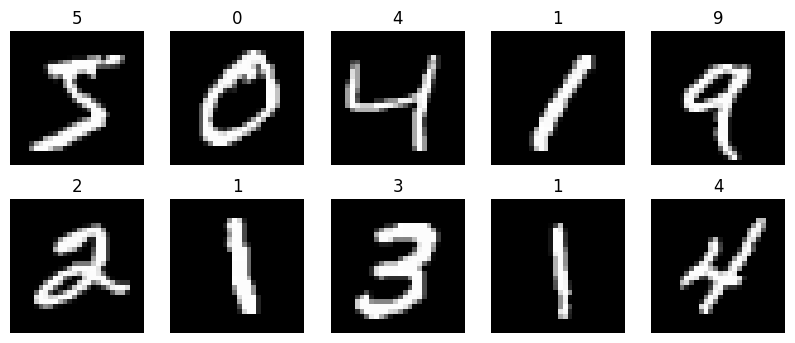

In [ ]:
train_data, test_data = fetch_dataset()
print(len(train_data))
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 1000, shuffle=False) # inference bsz=1000
debug_loader = torch.utils.data.DataLoader(train_data, bsz)
img, label = next(iter(debug_loader))
view_10(img, label)

In [ ]:
# get client dataloaders
iid_client_train_loader = iid_partition_loader(train_data, bsz = bsz)


iid:  tensor([54., 70., 55., 48., 60., 52., 64., 69., 60., 68.])


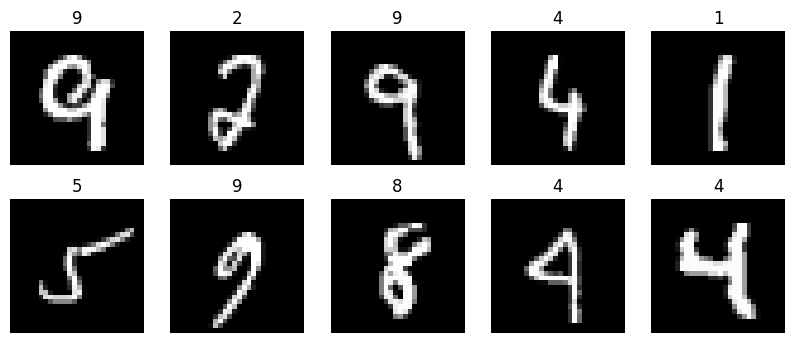

In [ ]:
# iid
label_dist = torch.zeros(10)
for (x,y) in iid_client_train_loader[25]:
    label_dist+= torch.sum(F.one_hot(y, num_classes=10), dim=0)
print("iid: ", label_dist)
view_10(x,y)

non-iid:  tensor([  0.,   0., 600.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])


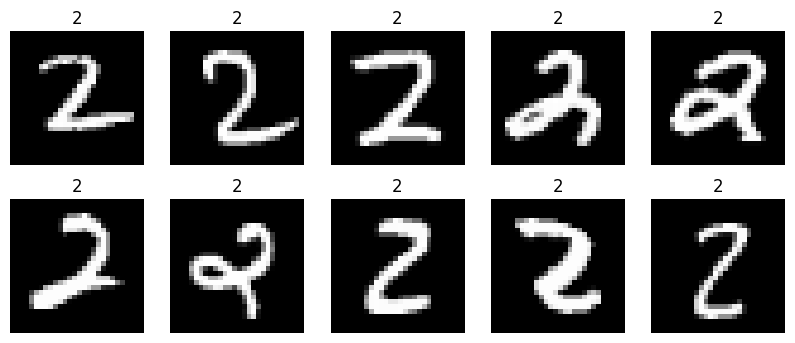

In [ ]:
# non-iid
noniid_client_train_loader = noniid_partition_loader(train_data, bsz = bsz)
label_dist = torch.zeros(10)
for (x,y) in noniid_client_train_loader[10]:
    label_dist+= torch.sum(F.one_hot(y,num_classes=10), dim=0)
print("non-iid: ", label_dist)
view_10(x,y)

In [ ]:
def num_params(model):
    """ """
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
# define cnn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(64*4*4, 1024)
        self.out = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 12, 12]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 4, 4]
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

print(CNN())
print(num_params(CNN()))

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)
1111946


In [ ]:
## Training

In [ ]:
criterion = nn.CrossEntropyLoss()
def validate(model):
    model = model.to(cuda)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for (t, (x,y)) in enumerate(test_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            out = model(x)
            correct += torch.sum(torch.argmax(out, dim=1) == y).item()
            total += x.shape[0]
    return correct/total

In [ ]:
def train_client(id, client_loader, global_model, num_local_epochs, lr):
    local_model = copy.deepcopy(global_model)
    local_model = local_model.to(cuda)
    local_model.train()
    optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(num_local_epochs):
        for (i, (x,y)) in enumerate(client_loader):
            x = x.to(cuda)
            y = y.to(cuda)
            optimizer.zero_grad()
            out = local_model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

    return local_model

def running_model_avg(current, next, scale):
    if current == None:
        current = next
        for key in current:
            current[key] = current[key] * scale
    else:
        for key in current:
            current[key] = current[key] + (next[key] * scale)
    return current
def fed_avg_experiment(global_model, num_clients_per_round, num_local_epochs, lr, client_train_loader, max_rounds, filename):
    round_accuracy = []
    for t in range(max_rounds):
        print("starting round {}".format(t))

        # choose clients
        clients = np.random.choice(np.arange(100), num_clients_per_round, replace = False)
        print("clients: ", clients)

        global_model.eval()
        global_model = global_model.to(cpu)
        running_avg = None

        for i,c in enumerate(clients):
            # train local client
            print("round {}, starting client {}/{}, id: {}".format(t, i+1,num_clients_per_round, c))
            local_model = train_client(c, client_train_loader[c], global_model, num_local_epochs, lr)

            # add local model parameters to running average
            running_avg = running_model_avg(running_avg, local_model.state_dict(), 1/num_clients_per_round)

        # set global model parameters for the next step
        global_model.load_state_dict(running_avg)

        # validate
        val_acc = validate(global_model)
        print("round {}, validation acc: {}".format(t, val_acc))
        round_accuracy.append(val_acc)

        if (t % 10 == 0):
          np.save(filename+'_{}'.format(t)+'.npy', np.array(round_accuracy))

    return np.array(round_accuracy)


In [ ]:
cnn = CNN()
print(cnn)
print("total params: ", num_params(cnn))
cpu='cpu'
cuda='cuda'


CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (out): Linear(in_features=1024, out_features=10, bias=True)
)
total params:  1111946


In [ ]:
# CNN - iid - E-1, B=10 experiment
cpu='cpu'
cuda='cuda'
cnn_iid_e1b10 = copy.deepcopy(cnn)
acc_cnn_iid_e1b10 = fed_avg_experiment(cnn_iid_e1b10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_iid_e1b10')
print(acc_cnn_iid_e1b10)
np.save('./acc_cnn_iid_e1b10.npy', acc_cnn_iid_e1b10)


starting round 0
clients:  [19 14 43 37 66  3 79 41 38 68]
round 0, starting client 1/10, id: 19
round 0, starting client 2/10, id: 14
round 0, starting client 3/10, id: 43
round 0, starting client 4/10, id: 37
round 0, starting client 5/10, id: 66
round 0, starting client 6/10, id: 3
round 0, starting client 7/10, id: 79
round 0, starting client 8/10, id: 41
round 0, starting client 9/10, id: 38
round 0, starting client 10/10, id: 68
round 0, validation acc: 0.8186
starting round 1
clients:  [34 35 46 36 63 78 82 60 56 61]
round 1, starting client 1/10, id: 34
round 1, starting client 2/10, id: 35
round 1, starting client 3/10, id: 46
round 1, starting client 4/10, id: 36
round 1, starting client 5/10, id: 63
round 1, starting client 6/10, id: 78
round 1, starting client 7/10, id: 82
round 1, starting client 8/10, id: 60
round 1, starting client 9/10, id: 56
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.8654
starting round 2
clients:  [80 47 90 41 26 98 54 66  2 24

In [ ]:
# 데이터 로더 다시 만들기 (bsz=50)
iid_client_train_loader_b50 = iid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_iid_e1b50 = copy.deepcopy(cnn)

# 실험
acc_cnn_iid_e1b50 = fed_avg_experiment(
    cnn_iid_e1b50,
    num_clients_per_round=10,              # m=10
    num_local_epochs=1,                    # E=1
    lr=0.05,
    client_train_loader=iid_client_train_loader_b50,  # bsz=50 설정된 데이터로더
    max_rounds=300,
    filename='./acc_cnn_iid_e1b50'
)

# 결과 출력 및 저장
print(acc_cnn_iid_e1b50)
np.save('./acc_cnn_iid_e1b50.npy', acc_cnn_iid_e1b50)


starting round 0
clients:  [ 7 78 45 96 73 48 54 31 52 84]
round 0, starting client 1/10, id: 7
round 0, starting client 2/10, id: 78
round 0, starting client 3/10, id: 45
round 0, starting client 4/10, id: 96
round 0, starting client 5/10, id: 73
round 0, starting client 6/10, id: 48
round 0, starting client 7/10, id: 54
round 0, starting client 8/10, id: 31
round 0, starting client 9/10, id: 52
round 0, starting client 10/10, id: 84
round 0, validation acc: 0.5676
starting round 1
clients:  [27 51 43 93 50 87 10 33 64 95]
round 1, starting client 1/10, id: 27
round 1, starting client 2/10, id: 51
round 1, starting client 3/10, id: 43
round 1, starting client 4/10, id: 93
round 1, starting client 5/10, id: 50
round 1, starting client 6/10, id: 87
round 1, starting client 7/10, id: 10
round 1, starting client 8/10, id: 33
round 1, starting client 9/10, id: 64
round 1, starting client 10/10, id: 95
round 1, validation acc: 0.7338
starting round 2
clients:  [66 56 68 80 88 92 89 15 96 40

In [ ]:
# CNN - non-iid - E=1,B=10 experiment
cnn_noniid_e1b10 = copy.deepcopy(cnn)
acc_cnn_noniid_e1b10 = fed_avg_experiment(cnn_noniid_e1b10, num_clients_per_round=10,
                                 num_local_epochs=1,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename = './acc_cnn_noniid_e1b10')
print(acc_cnn_noniid_e1b10)
np.save('./acc_cnn_noniid_e1b10.npy', acc_cnn_noniid_e1b10)


starting round 0
clients:  [38 77 40 96 71 83 23 20  2  3]
round 0, starting client 1/10, id: 38
round 0, starting client 2/10, id: 77
round 0, starting client 3/10, id: 40
round 0, starting client 4/10, id: 96
round 0, starting client 5/10, id: 71
round 0, starting client 6/10, id: 83
round 0, starting client 7/10, id: 23
round 0, starting client 8/10, id: 20
round 0, starting client 9/10, id: 2
round 0, starting client 10/10, id: 3
round 0, validation acc: 0.2083
starting round 1
clients:  [20 99 80 76 98 31 83  7  0 30]
round 1, starting client 1/10, id: 20
round 1, starting client 2/10, id: 99
round 1, starting client 3/10, id: 80
round 1, starting client 4/10, id: 76
round 1, starting client 5/10, id: 98
round 1, starting client 6/10, id: 31
round 1, starting client 7/10, id: 83
round 1, starting client 8/10, id: 7
round 1, starting client 9/10, id: 0
round 1, starting client 10/10, id: 30
round 1, validation acc: 0.5322
starting round 2
clients:  [69  7 26 11 37 19 10 51 14 33]
r

In [ ]:
# DataLoader 다시 생성: B = 50
noniid_loader_b50 = noniid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_noniid_e1b50 = copy.deepcopy(cnn)

# 실험 수행
acc_cnn_noniid_e1b50 = fed_avg_experiment(
    cnn_noniid_e1b50,
    num_clients_per_round=10,                  # m=10
    num_local_epochs=1,                        # E=1
    lr=0.05,
    client_train_loader=noniid_loader_b50,     # B=50, non-IID
    max_rounds=300,
    filename='./acc_cnn_noniid_e1b50'
)

# 결과 출력 및 저장
print(acc_cnn_noniid_e1b50)
np.save('./acc_cnn_noniid_e1b50.npy', acc_cnn_noniid_e1b50)


starting round 0
clients:  [91 73 81 80 95 82 28 98 57 32]
round 0, starting client 1/10, id: 91
round 0, starting client 2/10, id: 73
round 0, starting client 3/10, id: 81
round 0, starting client 4/10, id: 80
round 0, starting client 5/10, id: 95
round 0, starting client 6/10, id: 82
round 0, starting client 7/10, id: 28
round 0, starting client 8/10, id: 98
round 0, starting client 9/10, id: 57
round 0, starting client 10/10, id: 32
round 0, validation acc: 0.2936
starting round 1
clients:  [89 16 44 50  5 64 73 51 30 90]
round 1, starting client 1/10, id: 89
round 1, starting client 2/10, id: 16
round 1, starting client 3/10, id: 44
round 1, starting client 4/10, id: 50
round 1, starting client 5/10, id: 5
round 1, starting client 6/10, id: 64
round 1, starting client 7/10, id: 73
round 1, starting client 8/10, id: 51
round 1, starting client 9/10, id: 30
round 1, starting client 10/10, id: 90
round 1, validation acc: 0.3753
starting round 2
clients:  [56 44 52 39 61 50 33 74 81 17

In [ ]:
# CNN - iid - m=10 experiment
cnn_iid_e5b10 = copy.deepcopy(cnn)
acc_cnn_iid_e5b10 = fed_avg_experiment(cnn_iid_m10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = iid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_iid_e5b10')



starting round 0
clients:  [55 30 72 47 73 99 29 76 79 81]
round 0, starting client 1/10, id: 55
round 0, starting client 2/10, id: 30
round 0, starting client 3/10, id: 72
round 0, starting client 4/10, id: 47
round 0, starting client 5/10, id: 73
round 0, starting client 6/10, id: 99
round 0, starting client 7/10, id: 29
round 0, starting client 8/10, id: 76
round 0, starting client 9/10, id: 79
round 0, starting client 10/10, id: 81
round 0, validation acc: 0.9205
starting round 1
clients:  [70 11 81 69 17 28 98 43 27 74]
round 1, starting client 1/10, id: 70
round 1, starting client 2/10, id: 11
round 1, starting client 3/10, id: 81
round 1, starting client 4/10, id: 69
round 1, starting client 5/10, id: 17
round 1, starting client 6/10, id: 28
round 1, starting client 7/10, id: 98
round 1, starting client 8/10, id: 43
round 1, starting client 9/10, id: 27
round 1, starting client 10/10, id: 74
round 1, validation acc: 0.9418
starting round 2
clients:  [71 73 39 59 76 19 24 97  8 6

In [ ]:
print(acc_cnn_iid_m10)
np.save('./acc_cnn_iid_e5b10.npy', acc_cnn_iid_e5b10)

[0.9205 0.9418 0.9537 0.9606 0.9674 0.9704 0.9721 0.9739 0.9748 0.9766
 0.9772 0.9791 0.9797 0.9805 0.9806 0.9805 0.9814 0.9827 0.9829 0.9833
 0.9834 0.9841 0.9848 0.9846 0.9854 0.9852 0.9863 0.9852 0.9856 0.9858
 0.9864 0.987  0.9873 0.9877 0.9877 0.9884 0.9874 0.9869 0.9877 0.9874
 0.9881 0.9876 0.9875 0.9877 0.9882 0.9883 0.9884 0.9885 0.9885 0.9891
 0.9893 0.9888 0.9889 0.9897 0.9893 0.9892 0.9893 0.9895 0.9897 0.9896
 0.99   0.99   0.9894 0.9896 0.99   0.9902 0.9898 0.9896 0.9903 0.9895
 0.9898 0.9899 0.9903 0.99   0.9902 0.99   0.9909 0.9903 0.99   0.9898
 0.9897 0.9899 0.99   0.9906 0.9903 0.9898 0.9903 0.9905 0.9898 0.9905
 0.9905 0.9901 0.9907 0.9902 0.9909 0.9905 0.9907 0.9906 0.9904 0.9906]


In [ ]:
# DataLoader 다시 생성: B=50
iid_loader_b50 = iid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_iid_e5b50 = copy.deepcopy(cnn)

# 실험 실행
acc_cnn_iid_e5b50 = fed_avg_experiment(
    cnn_iid_e5b50,
    num_clients_per_round=10,                # m=10
    num_local_epochs=5,                      # E=5
    lr=0.05,
    client_train_loader=iid_loader_b50,      # B=50, IID
    max_rounds=300,
    filename='./acc_cnn_iid_e5b50'
)

# 결과 저장
print(acc_cnn_iid_e5b50)
np.save('./acc_cnn_iid_e5b50.npy', acc_cnn_iid_e5b50)


starting round 0
clients:  [54 64 44 31 50 23  9 93 26 40]
round 0, starting client 1/10, id: 54
round 0, starting client 2/10, id: 64
round 0, starting client 3/10, id: 44
round 0, starting client 4/10, id: 31
round 0, starting client 5/10, id: 50
round 0, starting client 6/10, id: 23
round 0, starting client 7/10, id: 9
round 0, starting client 8/10, id: 93
round 0, starting client 9/10, id: 26
round 0, starting client 10/10, id: 40
round 0, validation acc: 0.7533
starting round 1
clients:  [76 54 48 99 88 42  3  4 32 61]
round 1, starting client 1/10, id: 76
round 1, starting client 2/10, id: 54
round 1, starting client 3/10, id: 48
round 1, starting client 4/10, id: 99
round 1, starting client 5/10, id: 88
round 1, starting client 6/10, id: 42
round 1, starting client 7/10, id: 3
round 1, starting client 8/10, id: 4
round 1, starting client 9/10, id: 32
round 1, starting client 10/10, id: 61
round 1, validation acc: 0.8507
starting round 2
clients:  [79 18 25 95 90 21 74 98 94  3]


In [ ]:
# CNN - non-iid - m=10 experiment
cnn_noniid_e5b10 = copy.deepcopy(cnn)
acc_cnn_noniid_e5b10 = fed_avg_experiment(cnn_noniid_e5b10, num_clients_per_round=10,
                                 num_local_epochs=5,
                                 lr=0.05,
                                 client_train_loader = noniid_client_train_loader,
                                 max_rounds=300,
                                 filename='./acc_cnn_noniid_e5b10')
print(acc_cnn_noniid_e5b10)
np.save('./acc_cnn_noniid_e5b10.npy', acc_cnn_noniid_e5b10)


starting round 0
clients:  [48 20 15 93 25 99 11 50 89 88]
round 0, starting client 1/10, id: 48
round 0, starting client 2/10, id: 20
round 0, starting client 3/10, id: 15
round 0, starting client 4/10, id: 93
round 0, starting client 5/10, id: 25
round 0, starting client 6/10, id: 99
round 0, starting client 7/10, id: 11
round 0, starting client 8/10, id: 50
round 0, starting client 9/10, id: 89
round 0, starting client 10/10, id: 88
round 0, validation acc: 0.1092
starting round 1
clients:  [59 55 39  2 83 77 74 56 37 45]
round 1, starting client 1/10, id: 59
round 1, starting client 2/10, id: 55
round 1, starting client 3/10, id: 39
round 1, starting client 4/10, id: 2
round 1, starting client 5/10, id: 83
round 1, starting client 6/10, id: 77
round 1, starting client 7/10, id: 74
round 1, starting client 8/10, id: 56
round 1, starting client 9/10, id: 37
round 1, starting client 10/10, id: 45
round 1, validation acc: 0.4457
starting round 2
clients:  [68  8 81 73 78  6 49  3 64 98

In [ ]:
# DataLoader 다시 생성: B=50, non-IID
noniid_loader_b50 = noniid_partition_loader(train_data, bsz=50)

# 모델 복사
cnn_noniid_e5b50 = copy.deepcopy(cnn)

# 실험 실행
acc_cnn_noniid_e5b50 = fed_avg_experiment(
    cnn_noniid_e5b50,
    num_clients_per_round=10,                 # m=10
    num_local_epochs=5,                       # E=5
    lr=0.05,
    client_train_loader=noniid_loader_b50,    # B=50, non-IID
    max_rounds=300,
    filename='./acc_cnn_noniid_e5b50'
)

# 결과 저장
print(acc_cnn_noniid_e5b50)
np.save('./acc_cnn_noniid_e5b50.npy', acc_cnn_noniid_e5b50)



starting round 0
clients:  [91 33 76 64 30 87 84  1  5 94]
round 0, starting client 1/10, id: 91
round 0, starting client 2/10, id: 33
round 0, starting client 3/10, id: 76
round 0, starting client 4/10, id: 64
round 0, starting client 5/10, id: 30
round 0, starting client 6/10, id: 87
round 0, starting client 7/10, id: 84
round 0, starting client 8/10, id: 1
round 0, starting client 9/10, id: 5
round 0, starting client 10/10, id: 94
round 0, validation acc: 0.2365
starting round 1
clients:  [78 88 85 37 66 58 63 29 57 82]
round 1, starting client 1/10, id: 78
round 1, starting client 2/10, id: 88
round 1, starting client 3/10, id: 85
round 1, starting client 4/10, id: 37
round 1, starting client 5/10, id: 66
round 1, starting client 6/10, id: 58
round 1, starting client 7/10, id: 63
round 1, starting client 8/10, id: 29
round 1, starting client 9/10, id: 57
round 1, starting client 10/10, id: 82
round 1, validation acc: 0.3164
starting round 2
clients:  [85 97 60 42 22 76 27 58 90  0]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# acc-> accuracy mlp/cnn iid/non idd all vector fecthed and ploted

In [ ]:
acc_mlp_iid_e1b10 = np.load('./acc_cnn_iid_e1b10.npy')
acc_mlp_iid_e1b50 = np.load('./acc_cnn_iid_e1b50.npy')
acc_cnn_iid_e5b10 = np.load('./acc_cnn_iid_e5b10.npy')
acc_cnn_iid_e5b50 = np.load('./acc_cnn_iid_e5b50.npy')

In [ ]:
#non iid
acc_mlp_noniid_e1b10 = np.load('./acc_cnn_noniid_e1b10.npy')
acc_mlp_noniid_e1b50 = np.load('./acc_cnn_noniid_e1b50.npy')
acc_cnn_noniid_e5b10 = np.load('./acc_cnn_noniid_e5b10.npy)
acc_cnn_noniid_e5b50 = np.load('./acc_cnn_noniid_e5b50.npy')

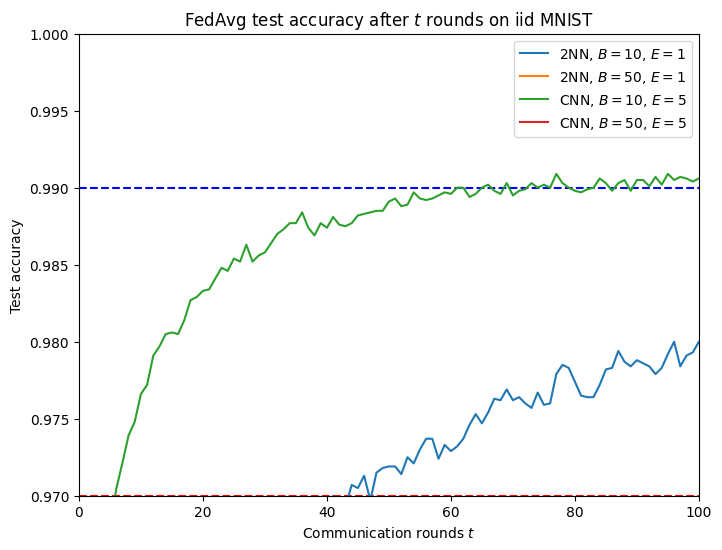

In [ ]:
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.97, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')

plt.plot(x, acc_cnn_iid_e1b10, label='CNN, $B=10$, $E=1$')
plt.plot(x,acc_cnn_iid_e1b50 , label='CNN, $B=50$, $E=1$')
plt.plot(x, acc_cnn_iid_e5b10, label='CNN, $B=10$, $E=5$')
plt.plot(x, acc_cnn_iid_e5b50, label='CNN, $B=50$, $E=5$')
#plt.plot(np.arange(1,52), acc_cnn_iid_m50, label='CNN, $m=50$, $E=5$')

plt.legend()

plt.show()

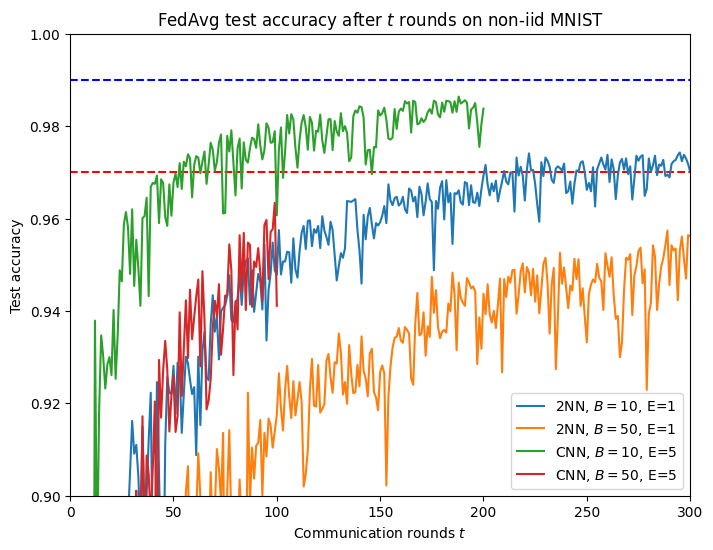

In [ ]:
x = np.arange(1,301)
plt.figure(figsize=(8,6))
plt.title("FedAvg test accuracy after $t$ rounds on non-iid MNIST")
plt.xlabel("Communication rounds $t$")
plt.ylabel("Test accuracy")
plt.axis([0, 300, 0.90, 1])
plt.axhline(y=0.97, color='r', linestyle='dashed')
plt.axhline(y=0.99, color='b', linestyle='dashed')
plt.plot(x, acc_mlp_noniid_e1b10, label='CNN, $B=10$, E=1')
plt.plot(x, acc_mlp_noniid_e1b50, label='CNN, $B=50$, E=1')
plt.plot(x, acc_cnn_noniid_e5b10, label='CNN, $B=10$, E=5')
plt.plot(x, acc_cnn_noniid_e5b50, label='CNN, $B=50$, E=5')
plt.legend()
plt.show()